## Load replay buffer

In [14]:
import pickle
from src.utils import load_replay_buffer

TASK_NAME="sac_circle_rotation_task_0"
N_SAMPLES:int=50_000
KERNEL_DIM=1
EPSILON_BALL = 0.005
EPSILON_LEVEL_SET = 0.0025

LEARN_KERNEL_BASES: bool=True


replay_buffer_name:str=TASK_NAME+"_replay_buffer.pkl"
kernel_bases_name:str=TASK_NAME+"_kernel_bases.pkl"


replay_buffer_task_1= load_replay_buffer(replay_buffer_name, N_steps=N_SAMPLES)

2025-07-01 10:30:06.632902: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/utils.py:68: UserWarning: Replay buffer contains more samples than selected.
  warnings.warn("Replay buffer contains more samples than selected.")


## Pointwise kernel bases of reward function

- We have $R(p)=n$ where $p=(s,a)$ and $n$ is the real-valued reward value.
- Learn the component of $G$ that acts on $S$ and the component of $G$ that acts on $A$ independently.

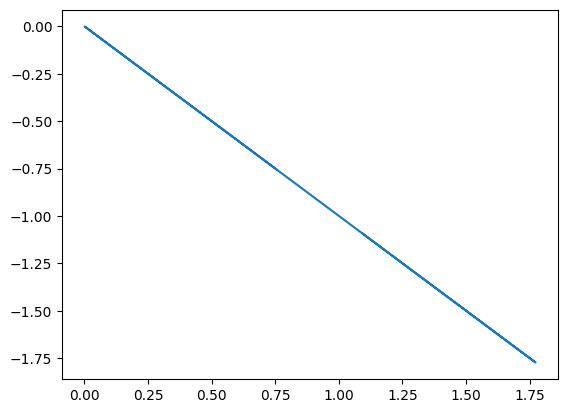

In [27]:
goal = torch.tensor([-0.70506063, 0.70914702])
distance_to_goal=torch.linalg.norm(next_ps - goal, dim=-1)
plt.plot(distance_to_goal, ns)

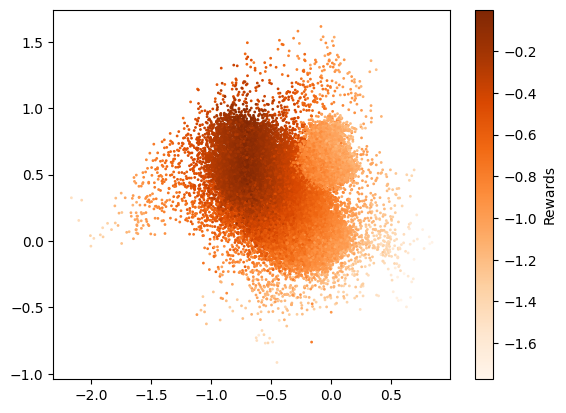

In [26]:
import torch
ps=replay_buffer_task_1["observations"]
next_ps=replay_buffer_task_1["next_observations"]
ns=replay_buffer_task_1["rewards"]

plt.scatter(next_ps[:, 0], next_ps[:, 1], c=ns, cmap='Oranges', s=1)
plt.colorbar(label='Rewards')

(-1.0, 1.0)

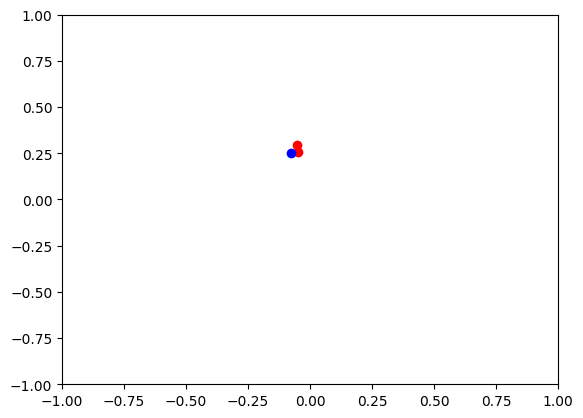

In [13]:
level_set=torch.tensor([[-0.0476,  0.2556],
        [-0.0516,  0.2946]])
point=torch.tensor([-0.0755,  0.2525])

plt.plot(level_set[:, 0], level_set[:, 1], 'ro', label='Level Set')
plt.plot(point[0], point[1], 'bo', label='Point')
plt.xlim(-1, 1)
plt.ylim(-1, 1)

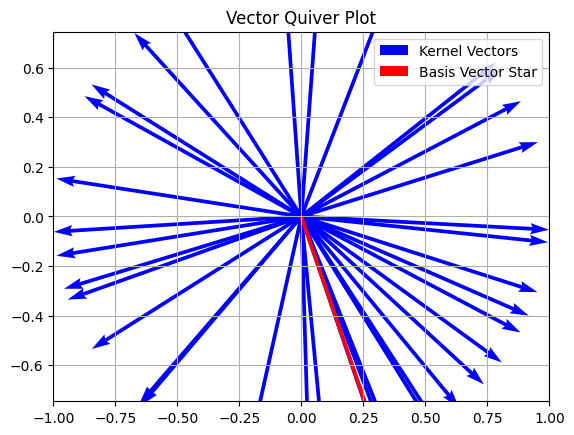

In [9]:
import matplotlib.pyplot as plt
import torch

# Define the vectors
kernel_vectors_point = torch.tensor([[-0.9882,  0.1530],
        [-0.9421, -0.3353],
        [ 0.3609,  0.9326],
        [ 0.5280, -0.8492],
        [ 0.9523, -0.3051],
        [ 0.9946, -0.1040],
        [-0.0703,  0.9975],
        [-0.6476, -0.7619],
        [ 0.3523, -0.9359],
        [-0.8744,  0.4852],
        [-0.6731,  0.7395],
        [-0.9565, -0.2916],
        [ 0.7845,  0.6201],
        [-0.5339,  0.8456],
        [ 0.8084, -0.5886],
        [ 0.0732,  0.9973],
        [ 0.3704, -0.9289],
        [-0.6539, -0.7566],
        [ 0.8038,  0.5950],
        [ 0.9986, -0.0534],
        [-0.8452, -0.5345],
        [ 0.9167, -0.3996],
        [ 0.9540,  0.2999],
        [-0.9874, -0.1584],
        [ 0.6364, -0.7713],
        [ 0.8838, -0.4678],
        [ 0.7360, -0.6770],
        [ 0.8854,  0.4649],
        [ 0.3216, -0.9469],
        [-0.2176, -0.9760],
        [-0.9981, -0.0620],
        [-0.8465,  0.5324],
        [ 0.0950, -0.9955],
        [ 0.0305, -0.9995],
        [ 0.5441, -0.8390]])


basis_vector_star = torch.tensor([
    [0.3243],
    [-0.9460]
])

# Set origin for all vectors at (0, 0)
origin = torch.zeros(kernel_vectors_point.shape[0], 2)

plt.quiver(
    origin[:, 0], origin[:, 1],
    kernel_vectors_point[:, 0], kernel_vectors_point[:, 1],
    angles='xy', scale_units='xy', scale=1, color='blue', label='Kernel Vectors'
)

plt.quiver(
    0, 0,
    basis_vector_star[0, 0], basis_vector_star[1, 0],
    angles='xy', scale_units='xy', scale=1, color='red', label='Basis Vector Star'
)


plt.axis('equal')
plt.grid(True)
plt.legend()
plt.title("Vector Quiver Plot")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()



In [2]:
from src.learning.symmetry_discovery.differential.kernel_approx import pointwise_kernel_approx, _compute_kernel_samples


ps=replay_buffer_task_1["observations"]
ns=replay_buffer_task_1["rewards"]

print("Shape of ps: ", ps.shape, " (should be (N_steps, |S|))")
print("Shape of ns: ", ns.shape, " (should be (N_steps))")

if LEARN_KERNEL_BASES:
    kernel_samples=pointwise_kernel_approx(p=ps, n=ns, kernel_dim=KERNEL_DIM, epsilon_ball=EPSILON_BALL, epsilon_level_set=EPSILON_LEVEL_SET)
    with open(kernel_bases_name, 'wb') as f:
        pickle.dump(kernel_samples, f)
else:
    with open(kernel_bases_name, 'rb') as f:
        kernel_samples = pickle.load(f)  

Shape of ps:  torch.Size([100000, 2])  (should be (N_steps, |S|))
Shape of ns:  torch.Size([100000])  (should be (N_steps))


/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/differential/kernel_approx.py:32: UserWarning: TODO: Dimension of kernel should be actively inferred, not passed as an argument.
  warnings.warn("TODO: Dimension of kernel should be actively inferred, not passed as an argument.")
/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/differential/kernel_approx.py:62: UserWarning: Kernel Approximation currently only supports real-valued functions.
  warnings.warn("Kernel Approximation currently only supports real-valued functions.")
INFO:root:Computing neighborhood of samples via kdtree...
Compute Point-Wise Bases via PCA...: 100%|██████████| 100000/100000 [00:01<00:00, 71556.65it/s]
INFO:root:Computed kernel bases from:
  - multiple tangent vectors for 13.36% of samples (good)
  - one tangent vector for 15.8% of samples (okay)
  - no tangent vector for 70.84% of samples (not good, no basis).


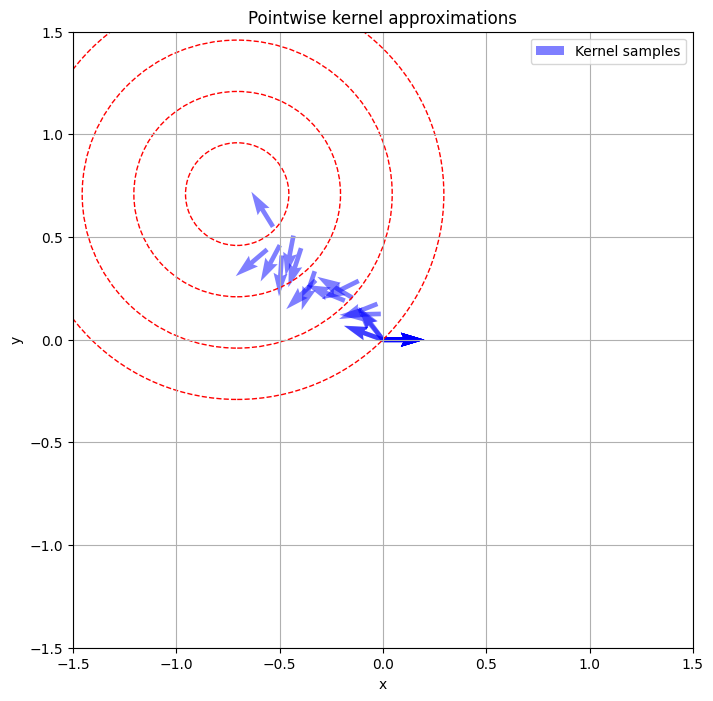

In [4]:
import numpy as np

import matplotlib.pyplot as plt


# Randomly select 100 indices from the sampled points
num_to_plot = 35
selected_indices = np.random.choice(list(kernel_samples.keys()), num_to_plot, replace=False)

# Select the corresponding points and vectors
points_to_plot = ps[selected_indices]
vectors_to_plot = [kernel_samples[idx] for idx in selected_indices]

vectors_to_plot = np.array([vectors_to_plot[i].flatten().numpy() for i in range(len(vectors_to_plot))])

# Plot the points and vectors using quiver
plt.figure(figsize=(8, 8))
plt.quiver(
    points_to_plot[:, 0], points_to_plot[:, 1], 
    vectors_to_plot[:, 0], vectors_to_plot[:, 1], 
    angles='xy', scale_units='xy', scale=5, color='blue', alpha=0.5, label="Kernel samples"
)

goal = np.array([-0.70506063, 0.70914702])
circle_radii = [0.25, 0.5, 0.75, 1]
for radius in circle_radii:
    circle = plt.Circle(goal, radius, color='red', fill=False, linestyle='--')
    plt.gca().add_artist(circle)

# Set plot limits and labels
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Pointwise kernel approximations')
plt.grid()
plt.legend()
plt.show()

## Learn Grassman Subspace

In [54]:
import torch
import torch.nn.functional as F

def kernel_weights(p_query, ps, bandwidth):
    dists = torch.norm(ps - p_query, dim=1)
    weights = torch.exp(-dists**2 / (2 * bandwidth**2))
    return weights / weights.sum()

def log_map_grassmann(V_ref, V):
    # V_ref, V: both (d, k), orthonormal bases as column vectors
    M = V_ref.T @ V  # (k, k)
    U, S, Vt = torch.linalg.svd(M)
    S = torch.clamp(S, -1.0 + 1e-6, 1.0 - 1e-6)
    Theta = torch.arccos(S)
    sin_Theta = torch.sin(Theta)
    sin_Theta[sin_Theta == 0] = 1e-6
    A = (V - V_ref @ M) @ torch.diag(Theta / sin_Theta)
    return A  # (d, k) in tangent space at V_ref

def exp_map_grassmann(V_ref, A):
    U, S, Vt = torch.linalg.svd(A, full_matrices=False)
    Theta = S
    sin_Theta = torch.sin(Theta)
    cos_Theta = torch.cos(Theta)
    term1 = V_ref @ (Vt.T @ torch.diag(cos_Theta) @ Vt)
    term2 = U @ torch.diag(sin_Theta) @ Vt
    V_new = term1 + term2
    return torch.linalg.qr(V_new, mode='reduced').Q  # (d, k)

In [55]:
def smooth_subspace(p_query, ps, kernel_samples, bandwidth, n_neighbors=20):
    """
    p_query: Tensor of shape (d,)
    ps: Tensor of shape (N, d)
    kernel_samples: dict {i: V_i}, each V_i of shape (d, k)
    bandwidth: float
    n_neighbors: number of closest samples to use
    Returns: (d, k) smoothed orthonormal basis
    """
    d = ps.shape[1]
    all_indices = torch.tensor(list(kernel_samples.keys()))
    ps_subset = ps[all_indices]  # (N, d)

    # Find n_neighbors closest points
    dists = torch.norm(ps_subset - p_query, dim=1)
    nn_dists, nn_indices = torch.topk(dists, k=n_neighbors, largest=False)
    selected_indices = all_indices[nn_indices]

    # Kernel weights
    weights = torch.exp(-nn_dists**2 / (2 * bandwidth**2))
    weights = weights / weights.sum()

    # Gather and orthonormalize bases
    V_bases = [
        torch.linalg.qr(kernel_samples[i], mode='reduced').Q  # (d, k)
        for i in selected_indices.tolist()
    ]

    # Use the nearest basis as reference
    V_ref = V_bases[0]  # (d, k)

    # Log maps and weighted tangent sum
    tangent_sum = torch.zeros_like(V_ref)
    for w, V_i in zip(weights, V_bases):
        W = log_map_grassmann(V_ref, V_i)  # (d, k)
        tangent_sum += w * W

    # Project back via exp map
    V_smooth = exp_map_grassmann(V_ref, tangent_sum)  # (d, k)
    return V_smooth


p_query = torch.tensor([0.7, 0.2])  # Example query point in the same space as ps

V_smooth = smooth_subspace(p_query, ps, kernel_samples, bandwidth=0.5, n_neighbors=20)

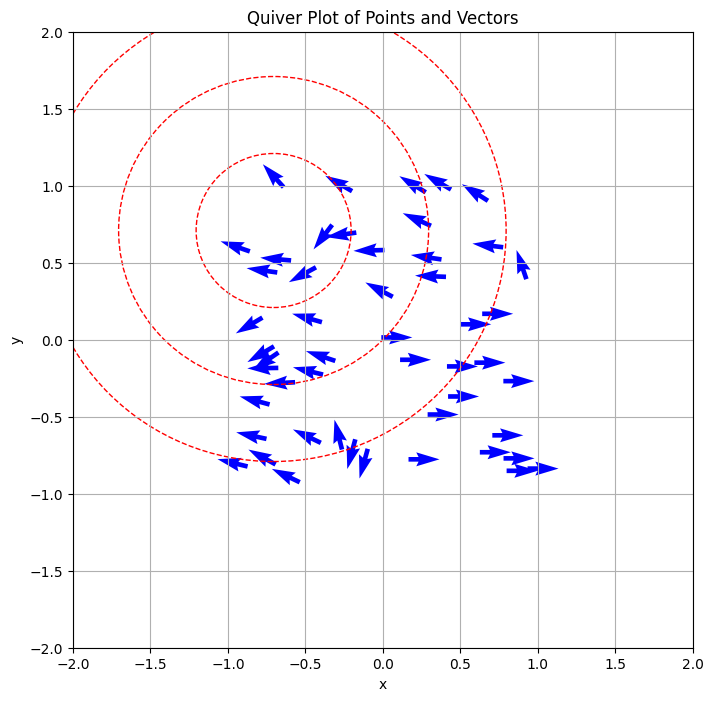

In [57]:
import numpy as np

import matplotlib.pyplot as plt

# Sample 50 points uniformly in the 2D plane
num_points = 50
x = np.random.uniform(-1, 1, num_points)
y = np.random.uniform(-1, 1, num_points)
points = np.stack([x, y], axis=1)

# Feed points into smooth_subspace and collect vectors
vectors = []
for point in points:
    p_query = torch.tensor(point, dtype=torch.float32)
    V_smooth = smooth_subspace(p_query, ps, kernel_samples, bandwidth=0.5, n_neighbors=20)
    vectors.append(V_smooth.numpy())  # Extract the first row of the smoothed subspace

vectors = np.array(vectors)
# Add circles around the specified goal point

# Plot points and vectors using quiver
plt.figure(figsize=(8, 8))
plt.quiver(points[:, 0], points[:, 1], vectors[:, 0], vectors[:, 1], angles='xy', scale_units='xy', scale=5, color='blue')


goal = np.array([-0.70506063, 0.70914702])
circle_radii = [0.5, 1, 1.5]
for radius in circle_radii:
    circle = plt.Circle(goal, radius, color='red', fill=False, linestyle='--')
    plt.gca().add_artist(circle)

plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Quiver Plot of Points and Vectors')
plt.grid()
plt.show()

In [8]:
import torch as th
from src.learning.symmetry_discovery.differential.diff_generator import DiffGenerator

g_0=th.randn(KERNEL_DIM, ps.shape[1], ps.shape[1], requires_grad=True)
optimizer= th.optim.Adam([g_0], lr=5e-5)
N_steps=10_000

linear_kernel=DiffGenerator(g_0=g_0, p=ps, bases=kernel_samples, n_steps=N_steps, optimizer=optimizer, batch_size=256)
linear_kernel.optimize()

/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/differential/diff_generator.py:195: UserWarning: TODO: only learns linear Kernel distributions.
  warnings.warn("TODO: only learns linear Kernel distributions.")
/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/differential/diff_generator.py:196: UserWarning: TODO: Implement early stopping in Kernel learning.
  warnings.warn("TODO: Implement early stopping in Kernel learning.")
/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/differential/diff_generator.py:58: UserWarning: TODO: Differential Generator is not Normalized During Training
  warnings.warn("TODO: Differential Generator is not Normalized During Training")
Loss: 2.0795e+02: 100%|██████████| 10000/10000 [00:21<00:00, 470.47it/s]


tensor([[[-1.0462, -0.0700],
         [-0.6525,  0.9691]]], requires_grad=True)